neutral: All
 Lifetimes for Entire range : [1.0, 0.001] ([0.0009247331696462, 1.763364812032078e-42])
neutral: NY
 Lifetimes for NY : [0.3, 1e-05] ([9.455852128267931e-06, 5.705851916784504e-13])
neutral: New England
 Lifetimes for New England : [0.6, 0.0001] ([6.408287874997985e-09, 4.714613873206991e-28])
neutral: OH/MI
 Lifetimes for OH/MI : [0.6, 0.0001] ([3.158829232227759e-08, 6.336442464690008e-22])


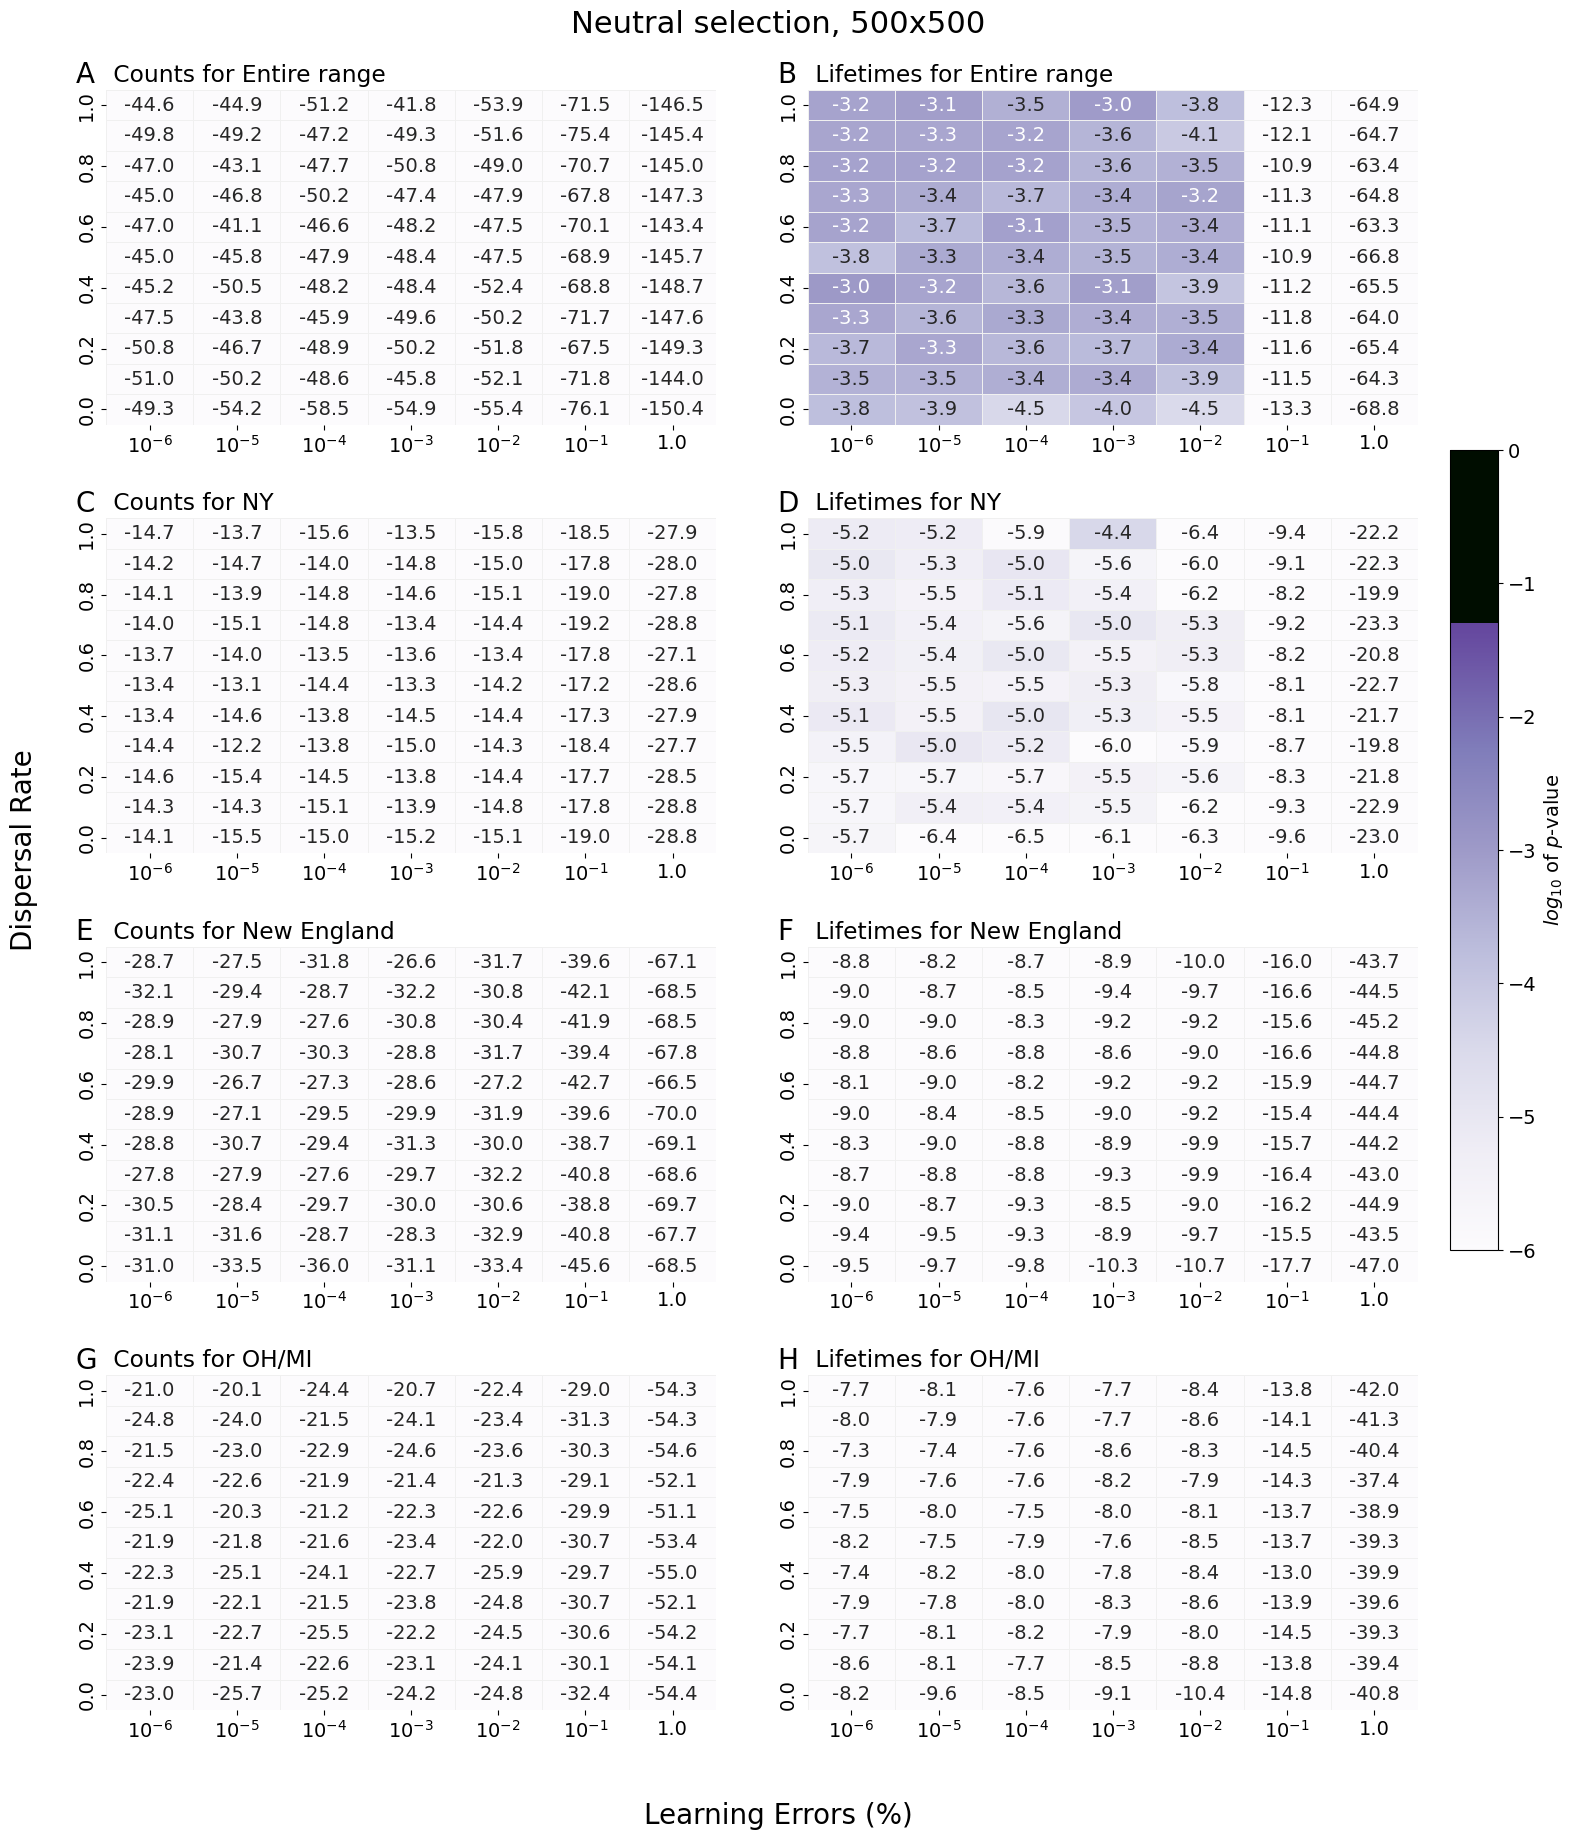

conformity_c=2: All


/home/pichkary/.local/lib/python3.11/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/pichkary/.local/lib/python3.11/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/pichkary/.local/lib/python3.11/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/pichkary/.local/lib/python3.11/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape

ValueError: zero-size array to reduction operation maximum which has no identity

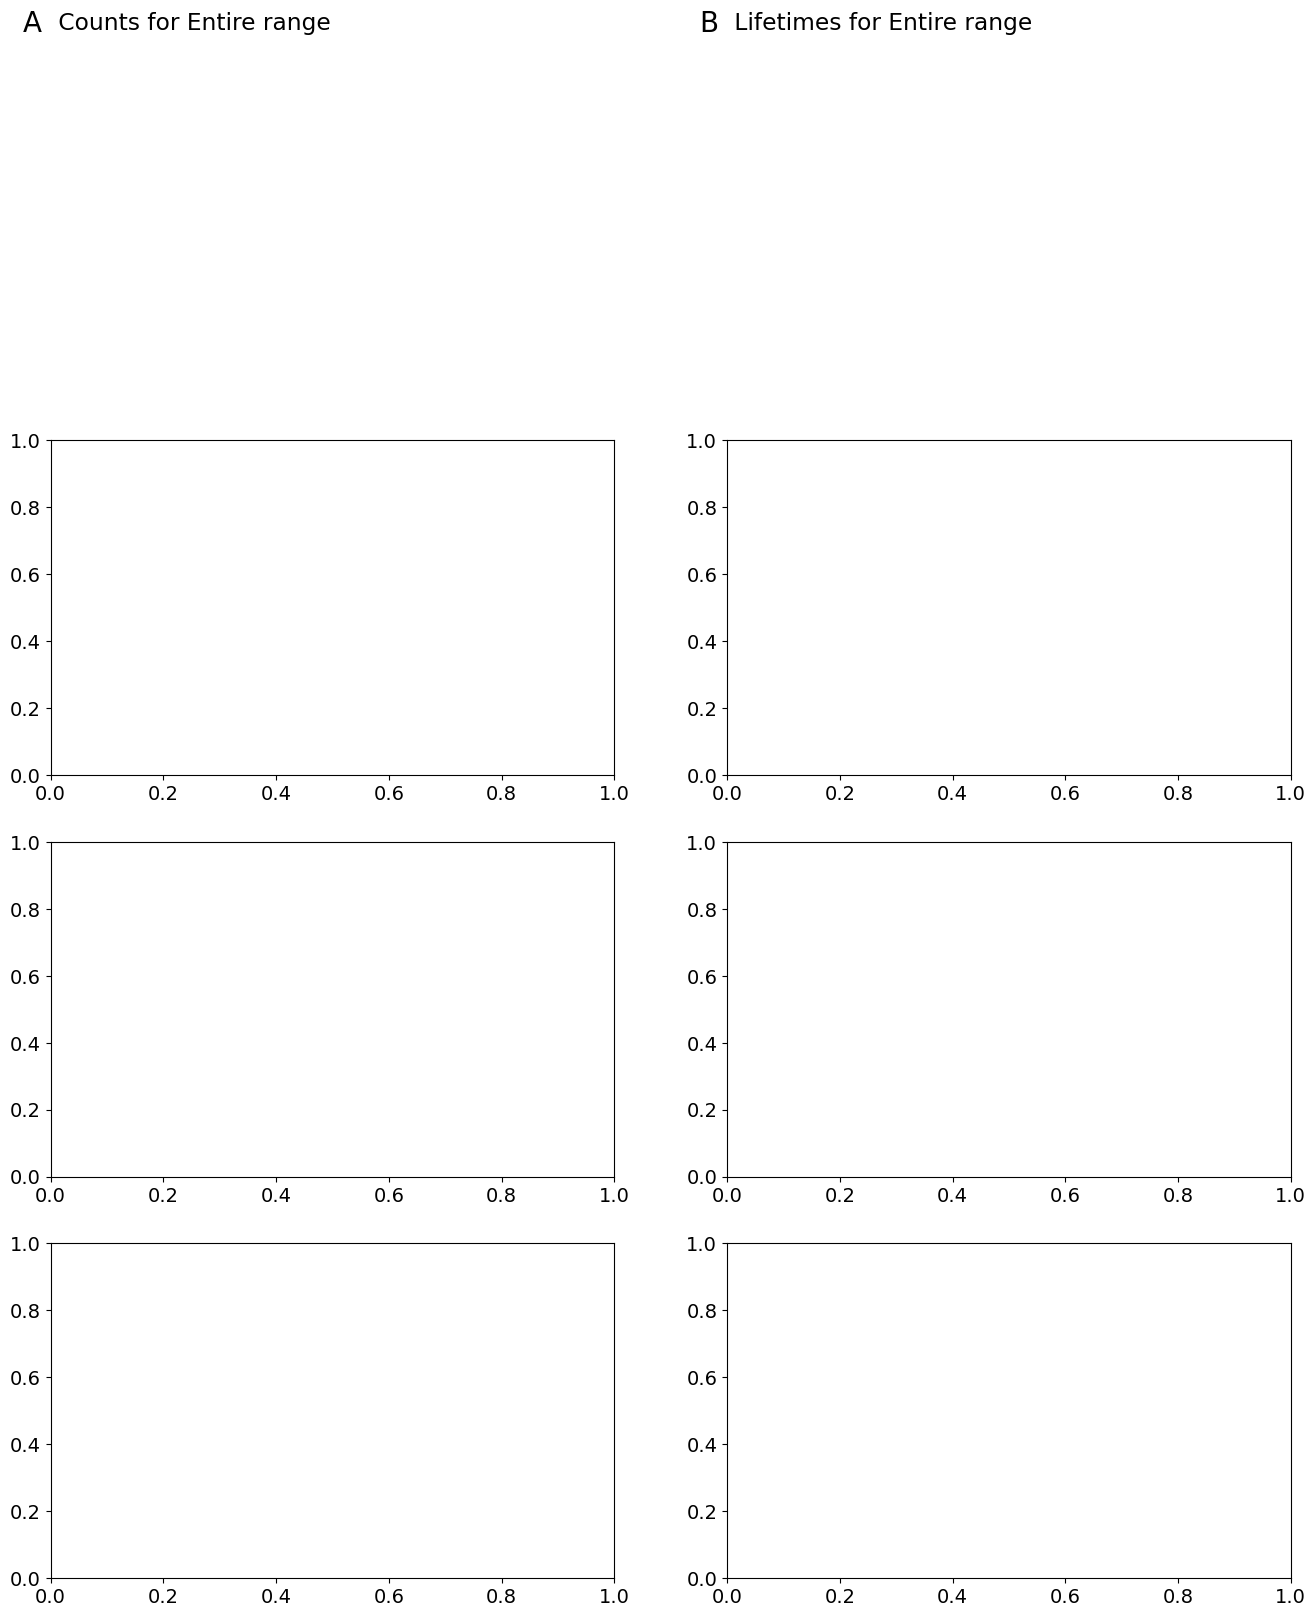

In [25]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from string import ascii_uppercase
from matplotlib import colormaps
from matplotlib.colors import ListedColormap


num_resamples = 512
purples = colormaps["Purples"].resampled(num_resamples)
custom_cmap = purples(np.linspace(0, 1, num_resamples))
colormap_lower = -6
approx005 = num_resamples - int(
    np.round(num_resamples * np.log10(0.05) / colormap_lower))
custom_cmap[approx005:, :] = np.array([0, 0.05, 0, 1])
custom_cmap = ListedColormap(custom_cmap)

plt.rcParams.update({'font.size': 14})
dim = 500  # 1581

for homoplasy in ("", "_hp"):

    df = pd.read_csv(f"fisher_{dim}dim" + homoplasy + ".csv", index_col=0)  # "fisher_1581dim.csv"

    for model_type in ("neutral", "conformity", "directional"):
        fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))

        df_used = df[df["model_type"]==model_type]

        if model_type is None:
            continue

        for area_num, area in enumerate(np.unique(df.area)):
            print(f"{model_type}: {area}")
            area_df = df_used[df_used["area"]==area]

            # calculate the best parameter combination:
            flat = []
            heatmap_old = None
            for c_or_f_num, c_or_f in enumerate(("counts", "lifetimes")):

                heatmap_data = pd.pivot_table(
                    area_df, values=c_or_f + "_fisher_R",
                    index='dispersal_rate',
                    columns='learning_error')

                if heatmap_old is None:
                    heatmap_old = heatmap_data.copy()
                flat.append(heatmap_data.values.flatten())

                ax = axes.flatten()[area_num * 2 + c_or_f_num]
                sns.heatmap(
                    np.log10(heatmap_data), ax=ax, vmin=colormap_lower, vmax=0,
                    cmap=custom_cmap, annot=True, fmt='2.1f', cbar=False,
                    linewidths=0.5, linecolor='#f0f0f0',
                    yticklabels=2)
                ax.invert_yaxis()
                xlabeltext = ax.xaxis.get_majorticklabels()
                for t in xlabeltext:
                    if float(t.get_text()) < 1:
                        t.set_text(re.sub(
                            "1e-0([0-9])",
                            "$\\\mathregular{10^{-\g<1>}}$",
                            "{:.0e}".format(
                                float(t.get_text()))))
                ax.xaxis.set_ticklabels(xlabeltext)

                title = f" {c_or_f.capitalize()} for {re.sub('All', 'Entire range', area)}"
                ax.set_title(title, loc='left')
                plt.text(-0.05, 1.02, ascii_uppercase[area_num * 2 + c_or_f_num],
                         ha='left', va='baseline', transform=ax.transAxes, size=20)
                ax.set_xlabel("", fontsize=0)
                ax.set_ylabel("", fontsize=0)

            ranks = [f.argsort().argsort() for f in flat]
            ranks = ranks[0] + ranks[1]
            max_rank = [i[0] for i in np.where(ranks.reshape(heatmap_data.shape) == ranks.max())]
            pvals = [heatmap_data.values[max_rank[0], max_rank[1]],
                     heatmap_old.values[max_rank[0], max_rank[1]]]
            print(f"{title} : "
                  f"{[h[r] for h,r in zip(heatmap_data.axes, max_rank)]} "
                  f"({pvals})")

        suptitle = f"{model_type.capitalize()} selection, {dim}x{dim}"
        if homoplasy:
            suptitle = suptitle.replace("selection", "selection with homoplasy")
        fig.suptitle(suptitle,
                     fontsize=22, y=0.92)
        fig.supxlabel("Learning Errors (%)", fontsize=20)
        fig.supylabel("Dispersal Rate", fontsize=20)
        cbar_ax = fig.add_axes([0.92, 0.3, 0.03, 0.4])
        fig.colorbar(axes[0, 0].collections[0], cax=cbar_ax,
                     label="$log_{10}$ of $p$-value")
        plt.subplots_adjust(bottom=0.07, left=0.08, wspace=0.15, hspace=0.28)
        area = area.replace("/", "-")
        area = area.replace(" ", "-")
        plt.savefig(f"figs/allRegions_dim{dim}" + homoplasy + f"_{model_type}.pdf", dpi=300)
        plt.savefig(f"figs/allRegions_dim{dim}" + homoplasy + f"_{model_type}.png", dpi=300)
        plt.show()



In [ ]:
# make plots *with* and *without* homoplasy for NY, 500x500, for each selection type

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from string import ascii_uppercase
from matplotlib import colormaps
from matplotlib.colors import ListedColormap


num_resamples = 512
purples = colormaps["Purples"].resampled(num_resamples)
custom_cmap = purples(np.linspace(0, 1, num_resamples))
colormap_lower = -6
approx005 = num_resamples - int(
    np.round(num_resamples * np.log10(0.05) / colormap_lower))
custom_cmap[approx005:, :] = np.array([0, 0.05, 0, 1])
custom_cmap = ListedColormap(custom_cmap)

plt.rcParams.update({'font.size': 14})
dim = 500  # 1581


for area_num, area in enumerate(np.unique(df.area)):
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(30, 20))
    
    for homoplasy in ("", "_hp"):
        df = pd.read_csv(f"fisher_{dim}dim" + homoplasy + ".csv", index_col=0)  # "fisher_1581dim.csv"

        for model_num, model_type in enumerate(
            ("neutral", "conformity", "directional")):

            df_used = df[df["model_type"]==model_type]


            print(f"{model_type}: {area}")
            area_df = df_used[df_used["area"]==area]

            # calculate the best parameter combination:
            flat = []
            heatmap_old = None
            for c_or_f_num, c_or_f in enumerate(("counts", "lifetimes")):

                heatmap_data = pd.pivot_table(
                    area_df[
                        (lambda x: (x > 10**-6) * (x < 10))(area_df["learning_error"])],
                    values=c_or_f + "_fisher_R",
                    index='dispersal_rate',
                    columns='learning_error')

                if heatmap_old is None:
                    heatmap_old = heatmap_data.copy()
                flat.append(heatmap_data.values.flatten())

                ax = axes[model_num][c_or_f_num + 2 * (homoplasy != '')]
                sns.heatmap(
                    np.log10(heatmap_data), ax=ax, vmin=colormap_lower, vmax=0,
                    cmap=custom_cmap, annot=True, fmt='2.1f', cbar=False,
                    linewidths=0.5, linecolor='#f0f0f0',
                    yticklabels=2)
                ax.invert_yaxis()
                xlabeltext = ax.xaxis.get_majorticklabels()
                for t in xlabeltext:
                    if float(t.get_text()) < 1:
                        t.set_text(re.sub(
                            "1e-0([0-9])",
                            "$\\\mathregular{10^{-\g<1>}}$",
                            "{:.0e}".format(
                                float(t.get_text()))))
                ax.xaxis.set_ticklabels(xlabeltext)

                title = f" {model_type} selection, {c_or_f.capitalize()}"
                if homoplasy:
                    title = title + " with homoplasy"
                else: 
                    title = title + ", no homoplasy"
                ax.set_title(title, loc='left')
                plt.text(-0.05, 1.02, ascii_uppercase[model_num + 3 * c_or_f_num + 6 * (homoplasy != '')],
                         ha='left', va='baseline', transform=ax.transAxes, size=20)
                ax.set_xlabel("", fontsize=0)
                ax.set_ylabel("", fontsize=0)

            ranks = [f.argsort().argsort() for f in flat]
            ranks = ranks[0] + ranks[1]
            max_rank = [i[0] for i in np.where(ranks.reshape(heatmap_data.shape) == ranks.max())]
            pvals = [heatmap_data.values[max_rank[0], max_rank[1]],
                     heatmap_old.values[max_rank[0], max_rank[1]]]
            print(f"{title} : "
                  f"{[h[r] for h,r in zip(heatmap_data.axes, max_rank)]} "
                  f"({pvals})")

    area_print = area.replace("All", "Entire range")
    suptitle = f"{area_print}, {dim}x{dim}"
    fig.suptitle(suptitle,
                 fontsize=22, y=0.92)
    fig.supxlabel("Learning Errors (%)", fontsize=20, y=0.038)
    fig.supylabel("Dispersal Rate", fontsize=20, x=0.055)
    cbar_ax = fig.add_axes([0.92, 0.3, 0.03, 0.4])
    fig.colorbar(axes[0, 0].collections[0], cax=cbar_ax,
                 label="$log_{10}$ of $p$-value")
    plt.subplots_adjust(bottom=0.07, left=0.08, wspace=0.15, hspace=0.28)
    area_print = area.replace("/", "-")
    area_print = area_print.replace(" ", "-")
    plt.savefig(f"figs/homomplasy_comparison_{area_print}_dim{dim}.pdf", dpi=300)
    plt.savefig(f"figs/homomplasy_comparison_{area_print}_dim{dim}.png", dpi=300)
    plt.show()



In [ ]:
# best fit syllable spectra for each area
import pickle


with open("syll_spectra_500.pickle", 'rb') as f:
    spectra_normal = pickle.load(f)
    
with open("syll_spectra_500_cf.pickle", 'rb') as f:
    spectra_1_2 = pickle.load(f)


# Entire range
# Lifetimes for neutral selection : [1.0, 0.001] ([0.0009247331696462, 1.763364812032078e-42])
# Lifetimes for conformity ($c$=1.2) selection : [0.1, 0.001] ([0.1092208319093223, 6.908279714427054e-17])
# Lifetimes for directional selection : [0.5, 0.01] ([0.1358901722301943, 0.000308289408489])
# NY
# Lifetimes for neutral selection : [0.3, 1e-05] ([9.455852128267931e-06, 5.705851916784504e-13])
# Lifetimes for conformity (c=1.2) selection : [0.1, 0.001] ([0.0008199943928486, 4.455248058691069e-08])
# Lifetimes for directional selection : [0.5, 1e-06] ([0.1231606089094363, 0.0044090544465235])
# OH/MI
# Lifetimes for neutral selection : [0.6, 0.0001] ([3.158829232227759e-08, 6.336442464690008e-22])
# Lifetimes for conformity (c=1.2) selection : [0.1, 0.001] ([0.0001345060966579, 1.070278227243379e-10])
# Lifetimes for directional selection : [0.5, 1e-06] ([0.0762319988391212, 0.0036861814729386])
# New England
# Lifetimes for neutral selection : [0.6, 0.0001] ([6.408287874997985e-09, 4.714613873206991e-28])
# Lifetimes for conformity (c=1.2) selection : [0.1, 0.001] ([3.6276493998616254e-05, 5.815234607536855e-13])
# Lifetimes for directional selection : [0.5, 0.0001] ([0.0545387549278721, 0.0001412074340598])
area_param_dict = {
    "All": ((0.001, 1.0), (0.001, 0.1), (0.01, 0.5)),
#     "NY": ((1e-5, 0.3), (0.001, 0.1), (1e-6, 0.5)),
    "OH/MI": ((0.0001, 0.6), (0.001, 0.1), (1e-6, 0.5)),
    "New England": ((0.001, 0.6), (0.001, 0.1), (0.0001, 0.5))
}

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))
c = ['k',
     '#5a7d7c',
     '#5fad56',
     '#f2c14e']

i = 0
for area_used in area_param_dict.keys():
    params = area_param_dict[area_used]

    params_print = [[
            "$\\mathregular{" + str(p[0]).replace("1e-0", "10^{-") + "}}$",
            p[1]
        ] if "e-" in str(p[0]) else [
            "$\\mathregular{" + str(p[0]) + "}$",
            p[1]
        ]
        for p in params]
    labels = [
        f'Empirical data from {area_used.replace("All", "the Entire range")}',
        f'Best Neutral ({params_print[0][0]}% err., {params_print[0][1]} disp.)',
        f'Best Conformity (c=1.2, {params_print[1][0]}% err., {params_print[1][1]} disp.)',
        f'Best Directional ({params_print[2][0]}% err., {params_print[2][1]} disp.)'
    ]
    params = [
        f'{area_used}',
        f'neutral_{params[0][0]}err_{params[0][1]}dispRate_{area_used}',
        f'conformity_c=1.2_{params[1][0]}err_{params[1][1]}dispRate_{area_used}',
        f'directional_{params[2][0]}err_{params[2][1]}dispRate_{area_used}'
    ]
    
    ax = axes[i][0]
    
    d = []
    for p in params:
        if p == area_used:
            d.append(
                spectra_normal['count_dict'][p])
            continue
        if "conformity" in p:
            d.append([])
            for k, v in spectra_1_2['count_dict'][p].items():
                d[-1].extend([k] * v)
            continue
        else:
            d.append([])
            for k, v in spectra_normal['count_dict'][p].items():
                d[-1].extend([k] * v)
    binning = np.arange(1, 2 + max([np.max(s) for s in d])) - 0.5
    ax.hist(
        d, bins=binning,
        label=labels, density=True, log=True,
        rwidth=0.8, color=c)
#     ax.legend(loc='upper right')
    plt.text(0.005, 0.99, ascii_uppercase[i * 2 ],
             ha='left', va='top', transform=ax.transAxes, size=25)
#     ax.set_title(f"Unbinned data for {area_used}")
    if i == 2:
        ax.set_xlabel('Unbinned syllable counts', fontsize=20)
    row_title = f"{area_used.replace('All', 'Entire range')}\n"  # if i == 0 else ""
    ax.set_ylabel(row_title + 'density of each count', fontsize=16)
    
    ax = axes[i][1]
    d = []
    for p in params:
        if p == area_used:
            d.append(
                spectra_normal['lifetime_dict'][p])
            continue
        if "conformity" in p:
            d.append([])
            for k, v in spectra_1_2['lifetime_dict'][p].items():
                d[-1].extend([k] * v)
            continue
        else:
            d.append([])
            for k, v in spectra_normal['lifetime_dict'][p].items():
                d[-1].extend([k] * v)
    binning = np.arange(1, 2 + max([np.max(s) for s in d])) - 0.5
    ax.hist(
        d, bins=binning,
        label=labels, density=True, log=True,
        rwidth=0.8, color=c)
    ax.legend(loc='upper right')
    plt.text(0.005, 0.99, ascii_uppercase[i * 2 + 1],
             ha='left', va='top', transform=ax.transAxes, size=25)
    if i == 2:
        ax.set_xlabel('Unbinned syllable lifetimes (years)', fontsize=20)
    ax.set_ylabel('density of each lifetime', fontsize=16)
    
    i += 1

fig.suptitle("Unbinned counts and lifetimes", fontsize=24, y=0.92)
# fig.tight_layout()
fig.savefig("figs/SuppFig_area_unbinned_best.pdf", dpi=300)
fig.savefig("figs/SuppFig_area_unbinned_best.png", dpi=300)
plt.show()


In [ ]:
# best fit syllable spectra for each model, individual plots
import pickle


with open("syll_spectra_500.pickle", 'rb') as f:
    spectra_normal = pickle.load(f)
    
with open("syll_spectra_500_cf.pickle", 'rb') as f:
    spectra_1_2 = pickle.load(f)

area_param_dict = {
    "NY": ((1e-5, 0.3), (0.001, 0.1), (1e-6, 0.5)),
    "OH/MI": ((0.0001, 0.6), (0.001, 0.1), (1e-6, 0.5)),
    "New England": ((0.001, 0.6), (0.001, 0.1), (0.0001, 0.5))
}

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 18))

area = "NY"
c = ['k',
     '#f2c14e',
     '#5a7d7c',
     '#5fad56']

params = area_param_dict[area]
params_print = [[
        "$\\mathregular{" + str(p[0]).replace("1e-0", "10^{-") + "}}$",
        p[1]
    ] if "e-" in str(p[0]) else [
        "$\\mathregular{" + str(p[0]) + "}$",
        p[1]
    ]
    for p in params
]
labels = [
    f'Empirical data from {area}',
    f'Best Directional\n({params_print[2][0]}% err., {params_print[2][1]} disp.)',
    f'Best Neutral\n({params_print[0][0]}% err., {params_print[0][1]} disp.)',
    f'Best Conformity\n(c=1.2, {params_print[1][0]}% err., {params_print[1][1]} disp.)',
]
params = [
    area,
    f'directional_{params[2][0]}err_{params[2][1]}dispRate_{area}',
    f'neutral_{params[0][0]}err_{params[0][1]}dispRate_{area}',
    f'conformity_c=1.2_{params[1][0]}err_{params[1][1]}dispRate_{area}'
]


count_hist = []
lifetime_hist = []
for p in params:
    if p == area:
        count_hist.append(
            spectra_normal['count_dict'][p])
        lifetime_hist.append(
            spectra_normal['lifetime_dict'][p])
    elif "conformity" in p:
        count_hist.append([])
        lifetime_hist.append([])
        for k, v in spectra_1_2['count_dict'][p].items():
            count_hist[-1].extend([k] * v)
        for k, v in spectra_1_2['lifetime_dict'][p].items():
            lifetime_hist[-1].extend([k] * v)
        continue
    else:
        count_hist.append([])
        lifetime_hist.append([])
        for k, v in spectra_normal['count_dict'][p].items():
            count_hist[-1].extend([k] * v)
        for k, v in spectra_normal['lifetime_dict'][p].items():
            lifetime_hist[-1].extend([k] * v)

i = 0
for label, color, counts, lifetimes in zip(
    labels, c, count_hist, lifetime_hist):
    params = area_param_dict[area_used]
    
    ax = axes[i // 2][i % 2]
    
    binning = np.arange(1, 2 + max([max(ct) for ct in count_hist])) - 0.5
    ax.hist(
        counts, bins=binning,
        density=True, log=True,
        rwidth=0.8, color=color)
#     ax.legend(loc='upper right')
    plt.text(0.005, 0.99, ascii_uppercase[i],
             ha='left', va='top', transform=ax.transAxes, size=20)
    ax.set_xlabel('Times each syllable was sampled', fontsize=14)
    ax.set_ylabel('Percent', fontsize=14)
    ax.set_ylim((0.001, 1))
    ax.set_title(label, y=0.85 - 0.1 * label.count("\n"))
    
    # relabel y-ticks to percentage
    ylabeltext = ax.yaxis.get_majorticklabels()
    for t in ylabeltext:
        labeltext = t.get_text()
        exponent = re.sub('.*\{([\-0-9]+)\}.*', "\g<1>", labeltext)
        new_exponent = str(int(exponent) + 2)
        labeltext = labeltext.replace(
            "{" + exponent + "}", "{" + new_exponent + "}")
        t.set_text(labeltext)
    ax.yaxis.set_ticklabels(ylabeltext)
    
    # lifetimes
    ax = axes[i // 2 + 2][i % 2]
    binning = np.arange(1, 2 + max([max(lf) for lf in lifetime_hist])) - 0.5
    ax.hist(
        lifetimes, bins=binning,
        density=True, log=True,
        rwidth=0.8, color=color)
#     ax.legend(loc='upper right')
    ax.yaxis.limit_range_for_scale(1e-2, 1e2)
    plt.text(0.005, 0.99, ascii_uppercase[i + 4],
             ha='left', va='top', transform=ax.transAxes, size=20)
    ax.set_xlabel('Syllable lifetime (years)', fontsize=14)
    ax.set_ylabel('Percent', fontsize=14)
    ax.set_ylim((0.001, 1))
    ax.set_title(label, y=0.85 - 0.1 * label.count("\n"))
    
    # relabel y-ticks to percentage
    ylabeltext = ax.yaxis.get_majorticklabels()
    for t in ylabeltext:
        labeltext = t.get_text()
        exponent = re.sub('.*\{([\-0-9]+)\}.*', "\g<1>", labeltext)
        new_exponent = str(int(exponent) + 2)
        labeltext = labeltext.replace(
            "{" + exponent + "}", "{" + new_exponent + "}")
        t.set_text(labeltext)
    ax.yaxis.set_ticklabels(ylabeltext)
    
    i += 1

fig.subplots_adjust(hspace=0.25)
fig.savefig(f"figs/SuppFig_{area}_unbinned_best.pdf", dpi=300)
fig.savefig(f"figs/SuppFig_{area}_unbinned_best.png", dpi=300)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# best fit syllable spectra for each area

def counts_relabeling(label, area):
    if area == "All":
        relabeling = {
            0: "1",
            1: "2-5",
            2: "6-10",
            3: "11-16",
            4: "16-25",
            5: "26-396"}
    if area == "NY":
        relabeling = {
            0: "1",
            1: "2",
            2: "3",
            3: "4",
            4: "5",
            5: "6-88"}
    if area == "OH/MI":
        relabeling = {
            0: "1",
            1: "2",
            2: "3",
            3: "4",
            4: "5",
            5: "6-172"}
    if area == "New England":
        relabeling = {
            0: "1",
            1: "2",
            2: "3",
            3: "4",
            4: "5",
            5: "6-210"}
    for i in range(-5, 15):
        if not i in relabeling.keys():
            relabeling[i] = None
    return relabeling[label]


def lifetime_relabeling(label):
    relabeling = {
        0: "1",
        1: "2-20",
        2: "21-34",
        3: "35-49",
        4: "50-57",
        5: "58-61",
        6: "62-68"}
    return relabeling[label]


# model_type = "directional"
area_param_dict = {
    "All": ((0.001, 1.0), (0.001, 0.1), (0.01, 0.5)),
#     "NY": ((1e-5, 0.3), (0.001, 0.1), (1e-6, 0.5)),
    "OH/MI": ((0.0001, 0.6), (0.001, 0.1), (1e-6, 0.5)),
    "New England": ((0.001, 0.6), (0.001, 0.1), (0.0001, 0.5))
}



fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))
c = ['k',
     '#5a7d7c',
     '#5fad56',
     '#f2c14e']

for i, area_used in enumerate(("All", "OH/MI", "New England")):
    params = area_param_dict[area_used]

    params_print = [[
            "$\\mathregular{" + str(p[0]).replace("1e-0", "10^{-") + "}}$",
            p[1]
        ] if "e-" in str(p[0]) else [
            "$\\mathregular{" + str(p[0]) + "}$",
            p[1]
        ]
        for p in params
    ]
    
    labels = [
        f'Empirical data from {area_used.replace("All", "Entire range")}',
        f'Best Neutral ({params_print[0][0]}% err., {params_print[0][1]} disp.)',
        f'Best Conformity ($c$=1.2, {params_print[1][0]}% err., {params_print[1][1]} disp.)',
        f'Best Directional ({params_print[2][0]}% err., {params_print[2][1]} disp.)'
    ]
    params = [
        f'{area_used}',
        f'neutral_{params[0][0]}err_{params[0][1]}dispRate_{area_used}',
        f'conformity_c=1.2_{params[1][0]}err_{params[1][1]}dispRate_{area_used}',
        f'directional_{params[2][0]}err_{params[2][1]}dispRate_{area_used}'
    ]
    
    ax = axes[i][0]
    d = []
    for p in params:
        if p == area_used:
            d.append(
                spectra_normal['count_binned_dict'][p])
            continue
        if "conformity" in p:
            d.append([])
            for k, v in spectra_1_2['count_binned_dict'][p].items():
                d[-1].extend([k] * v)
            continue
        else:
            d.append([])
            for k, v in spectra_normal['count_binned_dict'][p].items():
                d[-1].extend([k] * v)
    binning = np.arange(0, 2 + max([np.max(s) for s in d])) - 0.5
    ax.hist(
        d, bins=binning,
        label=labels, density=True, log=False,
        rwidth=0.8, color=c)
    ax.set_ylim((0, 1))
#     ax.legend(loc='upper right', fontsize=12)
    plt.text(0.01, 0.99, ascii_uppercase[i * 2],
             ha='left', va='top', transform=ax.transAxes, size=25)
    # set x-ticks to binned values
    xlabeltext = ax.xaxis.get_majorticklabels()
    xlabeltext = [
        '' if t.get_text() == '−1'
        else counts_relabeling(int(t.get_text()), area_used)
        for t in xlabeltext
    ]
    ax.set_xticks(ax.get_xticks(), xlabeltext)
#     ax.set_title(f"Unbinned data for {area_used}")
    if i == 2:
        ax.set_xlabel('Binned syllable counts', fontsize=20)
    row_title = f"{area_used.replace('All', 'Entire range')}\n"  # if i == 0 else ""
    ax.set_ylabel(row_title + 'density of each count bin', fontsize=16)
    
    ax = axes[i][1]
    d = []
    for p in params:
        if p == area_used:
            d.append(
                spectra_normal['lifetime_binned_dict'][p])
            continue
        if "conformity" in p:
            d.append([])
            for k, v in spectra_1_2['lifetime_binned_dict'][p].items():
                d[-1].extend([k] * v)
            continue
        else:
            d.append([])
            for k, v in spectra_normal['lifetime_binned_dict'][p].items():
                d[-1].extend([k] * v)
    binning = np.arange(0, 2 + max([np.max(s) for s in d])) - 0.5
    ax.hist(
        d, bins=binning,
        label=labels, density=True, log=False,
        rwidth=0.8, color=c)
    ax.legend(loc='upper right', fontsize=12)
    ax.set_ylim((0, 1))
    plt.text(0.01, 0.99, ascii_uppercase[i * 2 + 1],
             ha='left', va='top', transform=ax.transAxes, size=25)
    # set x-ticks to binned values
    xlabeltext = ax.xaxis.get_majorticklabels()
    for i in range(len(xlabeltext)):
        if xlabeltext[i].get_text() == '−1':
            xlabeltext[i] = ''
        elif xlabeltext[i].get_text() == '7':
            xlabeltext[i] = ''
        else:
            xlabeltext[i] = lifetime_relabeling(
                int(xlabeltext[i].get_text()))
    ax.set_xticks(ax.get_xticks(), xlabeltext)
    ax.set_ylabel('density of each lifetime bin', fontsize=16)

ax.set_xlabel('Binned syllable lifetimes (years)', fontsize=20)

fig.suptitle("Binned counts and lifetimes", fontsize=24, y=0.92)
# fig.tight_layout()
fig.savefig("figs/SuppFig_area_binned_best.pdf", dpi=300)
fig.savefig("figs/SuppFig_area_binned_best.png", dpi=300)
plt.show()


In [ ]:
# best fit syllable spectra (CONFORMITY FACTOR) for each area
import matplotlib.pyplot as plt

# best fit syllable spectra for NY

area_used = 'All'

def counts_relabeling(label, area):
    if area == "All":
        relabeling = {
            0: "1",
            1: "2-5",
            2: "6-10",
            3: "11-16",
            4: "16-25",
            5: "26-396"}
    if area == "NY":
        relabeling = {
            0: "1",
            1: "2",
            2: "3",
            3: "4",
            4: "5",
            5: "6-88"}
    if area == "OH/MI":
        relabeling = {
            0: "1",
            1: "2",
            2: "3",
            3: "4",
            4: "5",
            5: "6-172"}
    if area == "New England":
        relabeling = {
            0: "1",
            1: "2",
            2: "3",
            3: "4",
            4: "5",
            5: "6-210"}
    for i in range(-5, 15):
        if not i in relabeling.keys():
            relabeling[i] = None
    return relabeling[label]


def lifetime_relabeling(label):
    relabeling = {
        0: "1",
        1: "2-20",
        2: "21-34",
        3: "35-49",
        4: "50-57",
        5: "58-61",
        6: "62-68"}
    return relabeling[label]
    


# Lifetimes ($c=0.8$) : [0.1, 1e-05] ([1.0905103936429815e-06, 1.1365451158571465e-15])
# Lifetimes ($c=1$) : [0.3, 1e-05] ([9.455852128267931e-06, 5.705851916784504e-13])
# Lifetimes ($c=1.2$) : [0.1, 0.001] ([0.0008199943928486, 4.455248058691069e-08])
# Lifetimes ($c=1.4$) : [0.6, 0.01] ([0.000147969536706, 3.221099731959155e-11])
# Lifetimes ($c=1.6$) : [0.9, 0.1] ([6.023824447402271e-05, 6.531340456717769e-13])
# Lifetimes ($c=1.8$) : [0.3, 1e-05] ([3.1515955347964805e-05, 3.4409572494474e-13])
# Lifetimes ($c=2$) : [0.4, 0.001] ([2.429986602226697e-05, 1.1630471199351872e-13])
params = ((1e-5, 0.1),
          (1e-5, 0.3),
          (0.001, 0.1),
          (0.01, 0.6),
          (0.1, 0.9),
          (1e-5, 0.3),
          (1e-6, 0.5))
params_print = [[
        "$\\mathregular{" + str(p[0]).replace("1e-0", "10^{-") + "}}$",
        p[1]
    ] if "e-" in str(p[0]) else [
        "$\\mathregular{" + str(p[0]) + "}$",
        p[1]
    ]
    for p in params
]

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 18))
c = (np.linspace(
    (143, 223, 128, 256), (16, 130, 16, 256), 6) / 256).tolist()
c.insert(0, 'k')
c.insert(2, '#5a7d7c')

labels = [
    f'$S. passerina$ from {area_used}',
    f'Novelty ($c$=0.8, {params_print[0][0]}% err., {params_print[0][1]} disp.)',
    f'Neutral ($c$=1.0, {params_print[1][0]}% err., {params_print[1][1]} disp.)',
    f'Conformity ($c$=1.2, {params_print[2][0]}% err., {params_print[2][1]} disp.)',
    f'Conformity ($c$=1.4, {params_print[3][0]}% err., {params_print[3][1]} disp.)',
    f'Conformity ($c$=1.6, {params_print[4][0]}% err., {params_print[4][1]} disp.)',
    f'Conformity ($c$=1.8, {params_print[5][0]}% err., {params_print[5][1]} disp.)',
    f'Conformity ($c$=2.0, {params_print[6][0]}% err., {params_print[6][1]} disp.)'
]
params = [
    f'{area_used}',
    f'conformity_c=0.8_{params[0][0]}err_{params[0][1]}dispRate_{area_used}',
    f'neutral_{params[1][0]}err_{params[1][1]}dispRate_{area_used}',
    f'conformity_c=1.2_{params[2][0]}err_{params[2][1]}dispRate_{area_used}',
    f'conformity_c=1.4_{params[3][0]}err_{params[3][1]}dispRate_{area_used}',
    f'conformity_c=1.6_{params[4][0]}err_{params[4][1]}dispRate_{area_used}',
    f'conformity_c=1.8_{params[5][0]}err_{params[5][1]}dispRate_{area_used}',
    f'conformity_{params[6][0]}err_{params[6][1]}dispRate_{area_used}'
]

ax = axes[0]
d = []
for p in params:
    if p == area_used:
        d.append(
            spectra_normal['count_binned_dict'][p])
        continue
    if "conformity_c" in p:
        d.append([])
        for k, v in spectra_1_2['count_binned_dict'][p].items():
            d[-1].extend([k] * v)
        continue
    else:
        d.append([])
        for k, v in spectra_normal['count_binned_dict'][p].items():
            d[-1].extend([k] * v)
binning = np.arange(0, 2 + max([np.max(s) for s in d])) - 0.5
ax.hist(
    d, bins=binning,
    label=labels, density=True, log=False,
    rwidth=0.8, color=c)
# relabel y-ticks to percentage
ylabeltext = ax.yaxis.get_majorticklabels()
ylabeltext = [
    str(int(100 * float(t.get_text())))
    for t in ylabeltext]
ax.set_yticks(ax.get_yticks(), ylabeltext)
# set x-ticks to binned values
xlabeltext = ax.xaxis.get_majorticklabels()
xlabeltext = [
    '' if t.get_text() == '−1'
    else counts_relabeling(int(t.get_text()), area_used)
    for t in xlabeltext
]
ax.set_xticks(ax.get_xticks(), xlabeltext)

ax.legend(loc='upper right')
#     ax.set_title(f"Unbinned data for {area_used}")
ax.set_xlabel('Binned syllable counts', fontsize=20)
ax.set_ylabel('Percent of each count', fontsize=16)

ax = axes[1]
d = []
for p in params:
    if p == area_used:
        d.append(
            spectra_normal['lifetime_binned_dict'][p])
        continue
    if "conformity_c" in p:
        d.append([])
        for k, v in spectra_1_2['lifetime_binned_dict'][p].items():
            d[-1].extend([k] * v)
        continue
    else:
        d.append([])
        for k, v in spectra_normal['lifetime_binned_dict'][p].items():
            d[-1].extend([k] * v)
binning = np.arange(0, 2 + max([np.max(s) for s in d])) - 0.5
ax.hist(
    d, bins=binning,
    label=labels, density=True, log=False,
    rwidth=0.8, color=c)
# relabel y-ticks to percentage
ylabeltext = ax.yaxis.get_majorticklabels()
ylabeltext = [
    str(int(100 * float(t.get_text())))
    for t in ylabeltext]
ax.set_yticks(ax.get_yticks(), ylabeltext)
# set x-ticks to binned values
xlabeltext = ax.xaxis.get_majorticklabels()
for i in range(len(xlabeltext)):
    if xlabeltext[i].get_text() == '−1':
        xlabeltext[i] = ''
    elif xlabeltext[i].get_text() == '7':
        xlabeltext[i] = ''
    else:
        xlabeltext[i] = lifetime_relabeling(
            int(xlabeltext[i].get_text()))
ax.set_xticks(ax.get_xticks(), xlabeltext)
ax.set_xlabel('Binned syllable lifetimes (years)', fontsize=20)
ax.set_ylabel('Percent of each lifetime', fontsize=16)

### unbinned
ax = axes[2]
d = []
for p in params:
    if p == area_used:
        d.append(
            spectra_normal['count_dict'][p])
        continue
    if "conformity_c" in p:
        d.append([])
        for k, v in spectra_1_2['count_dict'][p].items():
            d[-1].extend([k] * v)
        continue
    else:
        d.append([])
        for k, v in spectra_normal['count_dict'][p].items():
            d[-1].extend([k] * v)
binning = np.arange(0, 2 + max([np.max(s) for s in d])) - 0.5
ax.hist(
    d, bins=binning,
    label=labels, density=True, log=False,
    rwidth=0.8, color=c)
# relabel y-ticks to percentage
ylabeltext = ax.yaxis.get_majorticklabels()
ylabeltext = [
    str(int(100 * float(t.get_text())))
    for t in ylabeltext]
ax.set_yticks(ax.get_yticks(), ylabeltext)
ax.set_xlabel('Syllable counts', fontsize=20)
ax.set_ylabel('Percent of each count', fontsize=16)

ax = axes[3]
d = []
for p in params:
    if p == area_used:
        d.append(
            spectra_normal['lifetime_dict'][p])
        continue
    if "conformity_c" in p:
        d.append([])
        for k, v in spectra_1_2['lifetime_dict'][p].items():
            d[-1].extend([k] * v)
        continue
    else:
        d.append([])
        for k, v in spectra_normal['lifetime_dict'][p].items():
            d[-1].extend([k] * v)
binning = np.arange(0, 2 + max([np.max(s) for s in d])) - 0.5
ax.hist(
    d, bins=binning,
    label=labels, density=True, log=False,
    rwidth=1, color=c)
# relabel y-ticks to percentage
ylabeltext = ax.yaxis.get_majorticklabels()
ylabeltext = [
    str(int(100 * float(t.get_text())))
    for t in ylabeltext]
ax.set_yticks(ax.get_yticks(), ylabeltext)
ax.set_xlabel('Syllable lifetimes (years)', fontsize=20)
ax.set_ylabel('Percent of each lifetime', fontsize=16)

# fig.suptitle("Binned counts and lifetimes", fontsize=24)
fig.tight_layout()
for i in range(4):
    plt.text(0.01, 0.99, ascii_uppercase[i],
             ha='left', va='top', transform=axes[i].transAxes, size=25)
    
# fig.savefig(f"figs/conformity_comparison_spectra_{area_used}_best.pdf", dpi=300)
# fig.savefig(f"figs/conformity_comparison_spectra_{area_used}_best.png", dpi=300)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# best fit syllable spectra for NY

area_used = 'NY'

def counts_relabeling(label, area):
    if area == "All":
        relabeling = {
            0: "1",
            1: "2-5",
            2: "6-10",
            3: "11-16",
            4: "16-25",
            5: "26-396"}
    if area == "NY":
        relabeling = {
            0: "1",
            1: "2",
            2: "3",
            3: "4",
            4: "5",
            5: "6-88"}
    if area == "OH/MI":
        relabeling = {
            0: "1",
            1: "2",
            2: "3",
            3: "4",
            4: "5",
            5: "6-172"}
    if area == "New England":
        relabeling = {
            0: "1",
            1: "2",
            2: "3",
            3: "4",
            4: "5",
            5: "6-210"}
    for i in range(-5, 15):
        if not i in relabeling.keys():
            relabeling[i] = None
    return relabeling[label]


def lifetime_relabeling(label):
    relabeling = {
        0: "1",
        1: "2-20",
        2: "21-34",
        3: "35-49",
        4: "50-57",
        5: "58-61",
        6: "62-68"}
    return relabeling[label]
    

# model_type = "directional"
params = ((1e-5, 0.3), (0.001, 0.1), (1e-6, 0.5))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 9))
c = ['k',
     '#5a7d7c',
     '#5fad56',
     '#f2c14e']

i = 0
params = area_param_dict[area_used]

labels = [
    f'$S. passerina$ from {area_used}',
    f'Neutral ({params[0][0]}% err., {params[0][1]} disp.)',
    f'Conformity (c=1.2, {params[1][0]}% err., {params[1][1]} disp.)',
    f'Directional ({params[2][0]}% err., {params[2][1]} disp.)'
]
params = [
    f'{area_used}',
    f'neutral_{params[0][0]}err_{params[0][1]}dispRate_{area_used}',
    f'conformity_c=1.2_{params[1][0]}err_{params[1][1]}dispRate_{area_used}',
    f'directional_{params[2][0]}err_{params[2][1]}dispRate_{area_used}'
]

ax = axes[0]
d = []
for p in params:
    if p == area_used:
        d.append(
            spectra_normal['count_binned_dict'][p])
        continue
    if "conformity" in p:
        d.append([])
        for k, v in spectra_1_2['count_binned_dict'][p].items():
            d[-1].extend([k] * v)
        continue
    else:
        d.append([])
        for k, v in spectra_normal['count_binned_dict'][p].items():
            d[-1].extend([k] * v)
binning = np.arange(0, 2 + max([np.max(s) for s in d])) - 0.5
ax.hist(
    d, bins=binning,
    label=labels, density=True, log=False,
    rwidth=0.8, color=c)
# relabel y-ticks to percentage
ylabeltext = ax.yaxis.get_majorticklabels()
ylabeltext = [
    str(int(100 * float(t.get_text())))
    for t in ylabeltext]
ax.set_yticks(ax.get_yticks(), ylabeltext)
# set x-ticks to binned values
xlabeltext = ax.xaxis.get_majorticklabels()
xlabeltext = [
    '' if t.get_text() == '−1'
    else counts_relabeling(int(t.get_text()), area_used)
    for t in xlabeltext
]
ax.set_xticks(ax.get_xticks(), xlabeltext)

ax.legend(loc='upper right')
#     ax.set_title(f"Unbinned data for {area_used}")
ax.set_xlabel('Binned syllable counts', fontsize=20)
ax.set_ylabel('Percent of each count', fontsize=16)

ax = axes[1]
d = []
for p in params:
    if p == area_used:
        d.append(
            spectra_normal['lifetime_binned_dict'][p])
        continue
    if "conformity" in p:
        d.append([])
        for k, v in spectra_1_2['lifetime_binned_dict'][p].items():
            d[-1].extend([k] * v)
        continue
    else:
        d.append([])
        for k, v in spectra_normal['lifetime_binned_dict'][p].items():
            d[-1].extend([k] * v)
binning = np.arange(0, 2 + max([np.max(s) for s in d])) - 0.5
ax.hist(
    d, bins=binning,
    label=labels, density=True, log=False,
    rwidth=0.8, color=c)
# relabel y-ticks to percentage
ylabeltext = ax.yaxis.get_majorticklabels()
ylabeltext = [
    str(int(100 * float(t.get_text())))
    for t in ylabeltext]
ax.set_yticks(ax.get_yticks(), ylabeltext)
# set x-ticks to binned values
xlabeltext = ax.xaxis.get_majorticklabels()
for i in range(len(xlabeltext)):
    if xlabeltext[i].get_text() == '−1':
        xlabeltext[i] = ''
    elif xlabeltext[i].get_text() == '7':
        xlabeltext[i] = ''
    else:
        xlabeltext[i] = lifetime_relabeling(
            int(xlabeltext[i].get_text()))
ax.set_xticks(ax.get_xticks(), xlabeltext)
ax.set_xlabel('Binned syllable lifetimes (years)', fontsize=20)
ax.set_ylabel('Percent of each lifetime', fontsize=16)

# fig.suptitle("Binned counts and lifetimes", fontsize=24)
fig.tight_layout()
plt.text(0.01, 0.99, "A",
         ha='left', va='top', transform=axes[0].transAxes, size=25)
plt.text(0.01, 0.99, "B",
         ha='left', va='top', transform=axes[1].transAxes, size=25)
fig.savefig(f"figs/{area_used}_binned_best.pdf", dpi=300)
fig.savefig(f"figs/{area_used}_binned_best.png", dpi=300)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# best fit UNBINNED syllable spectra for NY


area_used = 'NY'
    

# model_type = "directional"
params = ((1e-5, 0.3), (0.001, 0.1), (1e-6, 0.5))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 9))
c = ['k',
     '#5a7d7c',
     '#5fad56',
     '#f2c14e']

i = 0
params = area_param_dict[area_used]

labels = [
    f'$S. passerina$ from {area_used}',
    f'Neutral ({params[0][0]}% err., {params[0][1]} disp.)',
    f'Conformity (c=1.2, {params[1][0]}% err., {params[1][1]} disp.)',
    f'Directional ({params[2][0]}% err., {params[2][1]} disp.)'
]
params = [
    f'{area_used}',
    f'neutral_{params[0][0]}err_{params[0][1]}dispRate_{area_used}',
    f'conformity_c=1.2_{params[1][0]}err_{params[1][1]}dispRate_{area_used}',
    f'directional_{params[2][0]}err_{params[2][1]}dispRate_{area_used}'
]

ax = axes[0]
d = []
for p in params:
    if p == area_used:
        d.append(
            spectra_normal['count_dict'][p])
        continue
    if "conformity" in p:
        d.append([])
        for k, v in spectra_1_2['count_dict'][p].items():
            d[-1].extend([k] * v)
        continue
    else:
        d.append([])
        for k, v in spectra_normal['count_dict'][p].items():
            d[-1].extend([k] * v)
binning = np.arange(1, 2 + max([np.max(s) for s in d])) - 0.5
ax.hist(
    d, bins=binning,
    label=labels, density=True, log=False,
    rwidth=0.8, color=c, )
# relabel y-ticks to percentage
ylabeltext = ax.yaxis.get_majorticklabels()
ylabeltext = [
    str(int(100 * float(t.get_text())))
    for t in ylabeltext]
ax.set_yticks(ax.get_yticks(), ylabeltext)

ax.legend(loc='upper right')
#     ax.set_title(f"Unbinned data for {area_used}")
ax.set_xlabel('Syllable counts', fontsize=20)
ax.set_ylabel('Percent of each count', fontsize=16)

### lifetimes plot
ax = axes[1]
d = []
for p in params:
    if p == area_used:
        d.append(
            spectra_normal['lifetime_dict'][p])
        continue
    if "conformity" in p:
        d.append([])
        for k, v in spectra_1_2['lifetime_dict'][p].items():
            d[-1].extend([k] * v)
        continue
    else:
        d.append([])
        for k, v in spectra_normal['lifetime_dict'][p].items():
            d[-1].extend([k] * v)
binning = np.arange(1, 2 + max([np.max(s) for s in d])) - 0.5
ax.hist(
    d, bins=binning,
    label=labels, density=True, log=False,
    rwidth=0.8, color=c)
# relabel y-ticks to percentage
ylabeltext = ax.yaxis.get_majorticklabels()
ylabeltext = [
    str(int(100 * float(t.get_text())))
    for t in ylabeltext]
ax.set_yticks(ax.get_yticks(), ylabeltext)

ax.set_xlabel('Syllable lifetimes (years)', fontsize=20)
ax.set_ylabel('Percent of each lifetime', fontsize=16)

# fig.suptitle("Binned counts and lifetimes", fontsize=24)
fig.tight_layout()
plt.text(0.01, 0.99, "A",
         ha='left', va='top', transform=axes[0].transAxes, size=25)
plt.text(0.01, 0.99, "B",
         ha='left', va='top', transform=axes[1].transAxes, size=25)
fig.savefig(f"figs/{area_used}_unbinned_best.pdf", dpi=300)
fig.savefig(f"figs/{area_used}_unbinned_best.png", dpi=300)
plt.show()

Lifetimes for neutral
selection in the entire range : [1.0, 0.001] ([0.0009247331696462, 1.763364812032078e-42])
Lifetimes for conformity ($c$=1.2)
selection in the entire range : [0.1, 0.001] ([0.1092208319093223, 6.908279714427054e-17])
Lifetimes for directional
selection in the entire range : [0.5, 0.01] ([0.1358901722301943, 0.000308289408489])
Lifetimes for neutral
selection in OH/MI : [0.6, 0.0001] ([3.158829232227759e-08, 6.336442464690008e-22])
Lifetimes for conformity ($c$=1.2)
selection in OH/MI : [0.1, 0.001] ([0.0001345060966579, 1.070278227243379e-10])
Lifetimes for directional
selection in OH/MI : [0.5, 1e-06] ([0.0762319988391212, 0.0036861814729386])
Lifetimes for neutral
selection in New England : [0.6, 0.0001] ([6.408287874997985e-09, 4.714613873206991e-28])
Lifetimes for conformity ($c$=1.2)
selection in New England : [0.1, 0.001] ([3.6276493998616254e-05, 5.815234607536855e-13])
Lifetimes for directional
selection in New England : [0.5, 0.0001] ([0.0545387549278721,

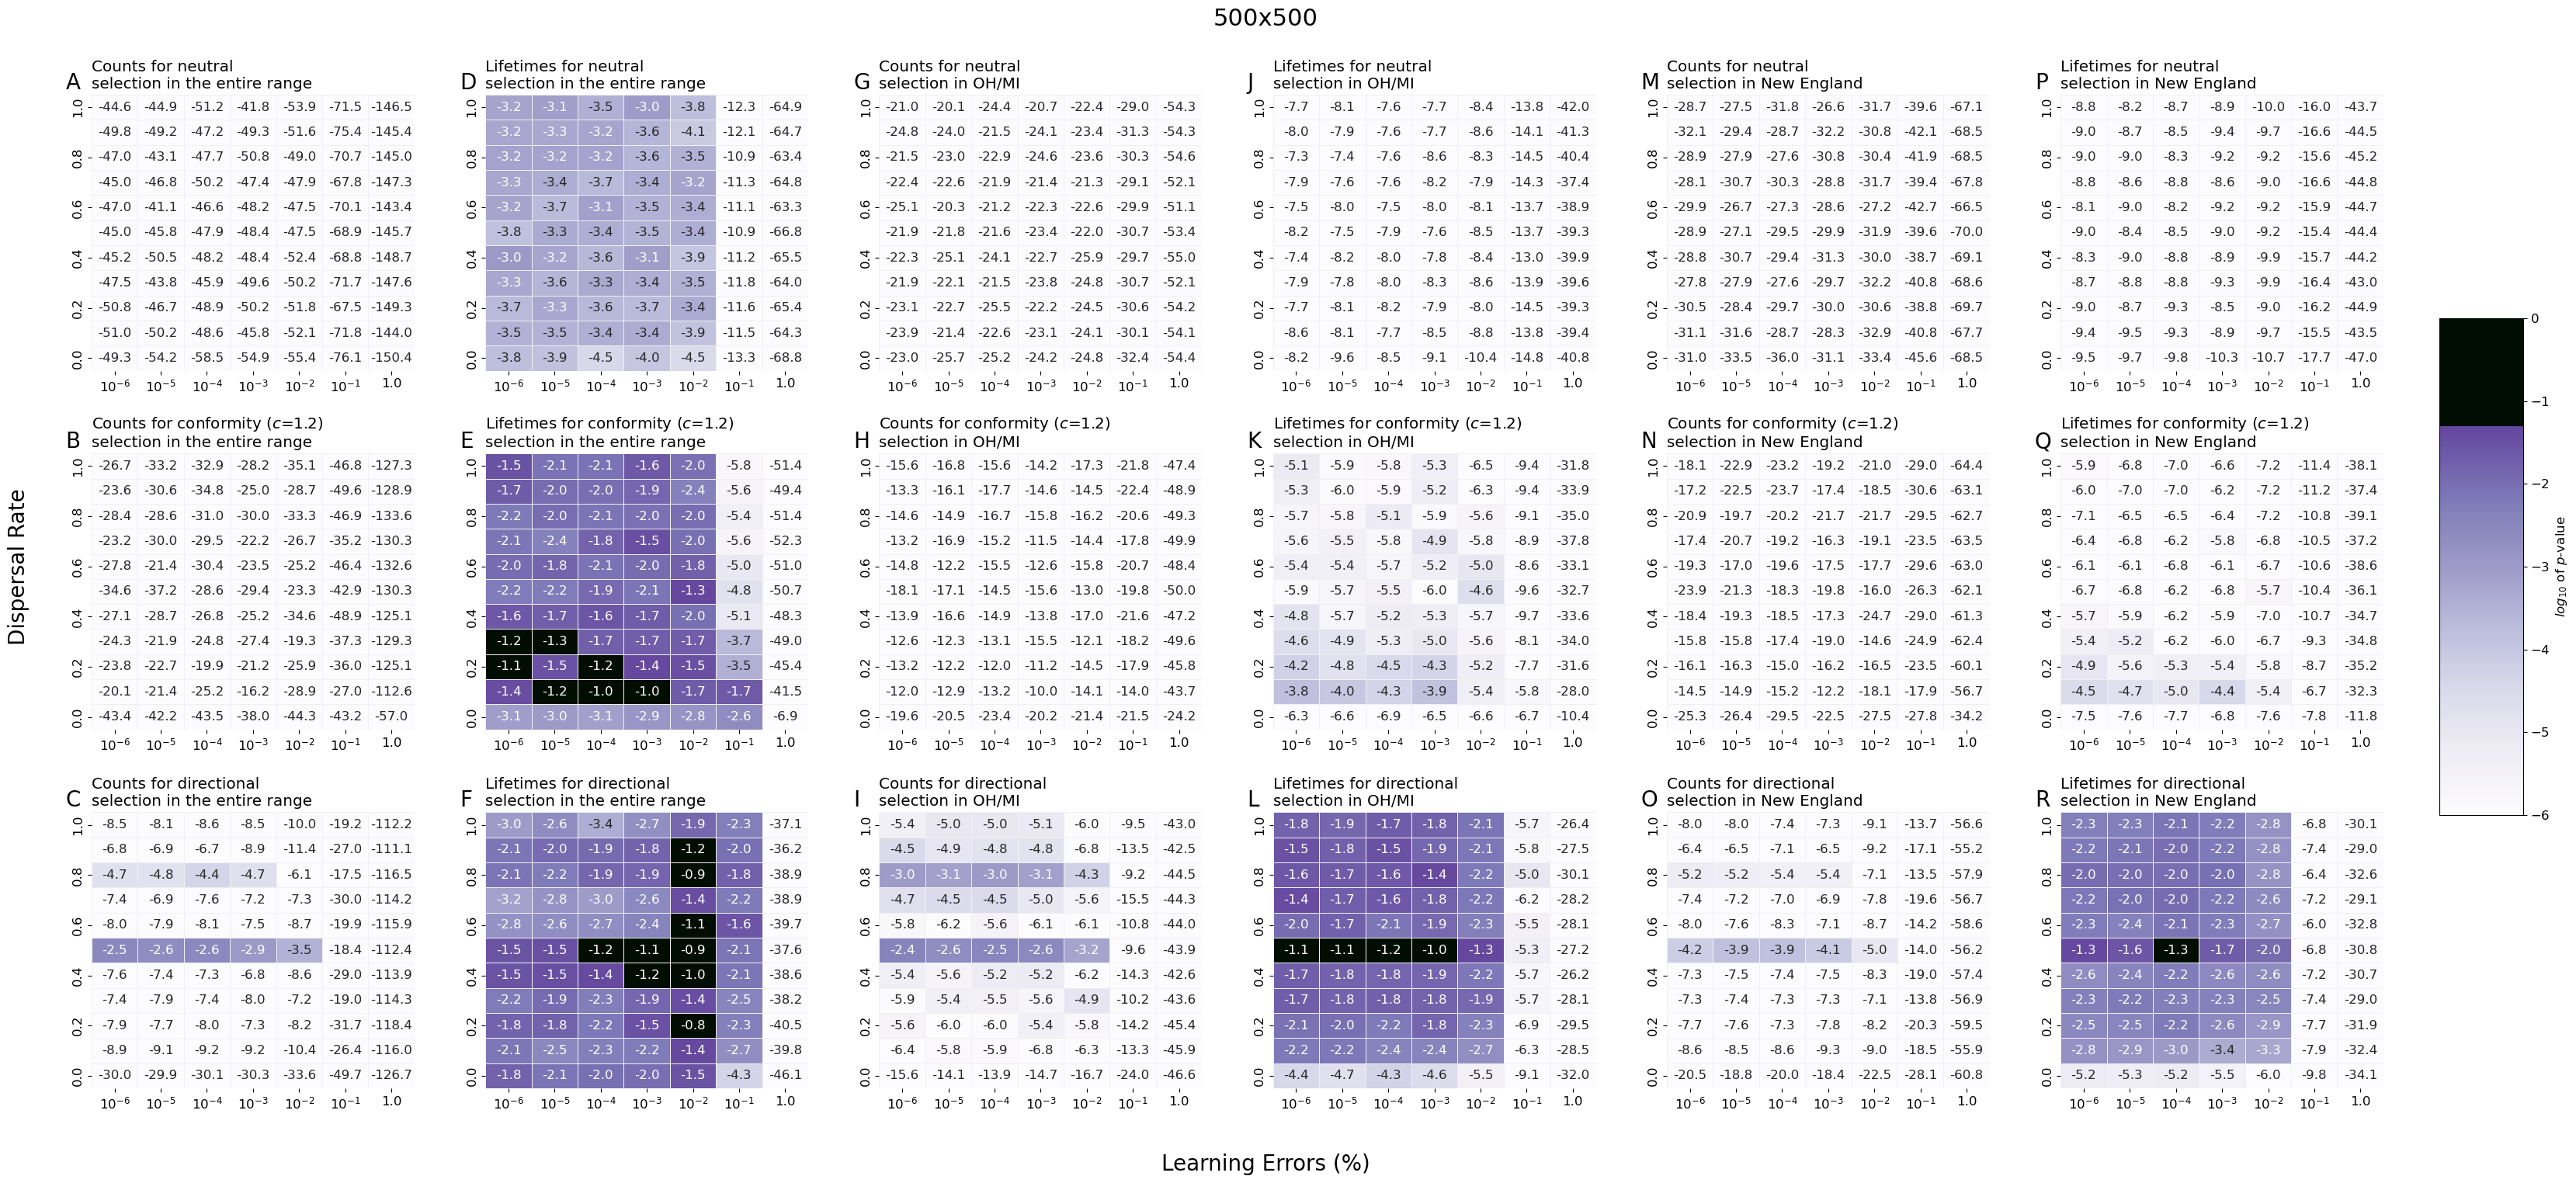

In [33]:
# Create 6 heatmaps for 1 region, comparing counts and lifetimes,
#  across 3 forms of selection (neutral, [best] conformity, directional)
#  for a single matrix size

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colormaps
from matplotlib.colors import ListedColormap


num_resamples = 512
purples = colormaps["Purples"].resampled(num_resamples)
custom_cmap = purples(np.linspace(0, 1, num_resamples))
colormap_lower = -6
approx005 = num_resamples - int(
    np.round(num_resamples * np.log10(0.05) / colormap_lower))
custom_cmap[approx005:, :] = np.array([0, 0.05, 0, 1])
custom_cmap = ListedColormap(custom_cmap)

plt.rcParams.update({'font.size': 12})
dim = 500  # 1581
df = pd.read_csv(f"fisher_{dim}dim.csv", index_col=0)
df_c = pd.read_csv("fisher_500dim_cf.csv", index_col=0)

fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(36, 16))

for area_num, area in enumerate(("All", "OH/MI", "New England")):  # , "NY"

    # (rows are selection types, columns are measurement types (counts/lifetimes))
#     area = "OH/MI"
    df_combined = pd.concat([df, df_c])
    df_combined = df_combined[df_combined["area"] == area]

    area = area.replace("All", "the entire range")
    
    for model_type_number, model_type in \
        enumerate(("neutral", "conformity_c=1.2", "directional")):

        df_model_type = df_combined[df_combined["model_type"] == model_type]

        # calculate the best parameter combination:
        flat = []
        heatmap_old = None
        for c_or_f_num, c_or_f in enumerate(("counts", "lifetimes")):

            heatmap_data = pd.pivot_table(
                df_model_type,
                values=c_or_f + "_fisher_R",
                index='dispersal_rate',
                columns='learning_error')

            if heatmap_old is None:
                heatmap_old = heatmap_data.copy()
            flat.append(heatmap_data.values.flatten())

            ax = axes[model_type_number][area_num * 2 + c_or_f_num]
            sns.heatmap(
                np.log10(heatmap_data), ax=ax, vmin=colormap_lower, vmax=0,
                cmap=custom_cmap, annot=True, fmt='3.1f', cbar=False,
                linewidths=0.5, linecolor='#f0f0f0',
                yticklabels=2)
            ax.invert_yaxis()
            xlabeltext = ax.xaxis.get_majorticklabels()
            for t in xlabeltext:
                if float(t.get_text()) != 1:
                    t.set_text(re.sub(
                        "1e-0([0-9])",
                        "$\\\mathregular{10^{-\g<1>}}$",
                        "{:.0e}".format(
                            float(t.get_text()))))
            ax.xaxis.set_ticklabels(xlabeltext)

            title = f"{c_or_f.capitalize()} for "\
                     "{}\nselection in {}".format(
                re.sub('mity_c=(.+)$', 'mity ($c$=\g<1>)', model_type), area)
            ax.set_title(title, loc='left')
            plt.text(-0.08, 1.02, ascii_uppercase[model_type_number + c_or_f_num * 3 + area_num * 6],
                     ha='left', va='baseline', transform=ax.transAxes, size=20)
            ax.set_xlabel("", fontsize=0)
            ax.set_ylabel("", fontsize=0)

        ranks = [f.argsort().argsort() for f in flat]
        ranks = ranks[0] + ranks[1]
        max_rank = [i[0] for i in np.where(ranks.reshape(heatmap_data.shape) == ranks.max())]
        pvals = [heatmap_data.values[max_rank[0], max_rank[1]],
                 heatmap_old.values[max_rank[0], max_rank[1]]]
        print(f"{title} : "
              f"{[h[r] for h,r in zip(heatmap_data.axes, max_rank)]} "
              f"({pvals})")

fig.suptitle(f"{dim}x{dim}", fontsize=22, y=0.95)  # .capitalize()
fig.supxlabel("Learning Errors (%)", fontsize=20) # y=0.05)
fig.supylabel("Dispersal Rate", fontsize=20, x=0.05)
cbar_ax = fig.add_axes([0.92, 0.3, 0.03, 0.4])
fig.colorbar(axes[0, 0].collections[0], cax=cbar_ax,
             label="$log_{10}$ of $p$-value")
plt.subplots_adjust(bottom=0.08, left=0.08, wspace=0.22, hspace=0.3)
#     area = area.replace("/", "-")
#     area = area.replace(" ", "-")
#     plt.savefig("figs/model_comparison_{}_dim{}.pdf".format(area, dim), dpi=300)
#     plt.savefig("figs/model_comparison_{}_dim{}.png".format(area, dim), dpi=300)
plt.savefig("figs/model_comparison_nonNY_dim{}.png".format(dim), dpi=300)
plt.show()


In [ ]:
# Create 6 (or 8) heatmaps for 1 region, comparing counts and lifetimes,
#  across 3 or 4 matrix sizes (400, 500, 600, [700]) for directional selection
#  and a single area

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colormaps
from matplotlib.colors import ListedColormap


num_resamples = 512
purples = colormaps["Purples"].resampled(num_resamples)
custom_cmap = purples(np.linspace(0, 1, num_resamples))
colormap_lower = -6
approx005 = num_resamples - int(
    np.round(num_resamples * np.log10(0.05) / colormap_lower))
custom_cmap[approx005:, :] = np.array([0, 0.05, 0, 1])
custom_cmap = ListedColormap(custom_cmap)

for area in ("All", "NY", "OH/MI", "New England"):
    sizes_to_compare = 4  # 4
    for model_type in ("neutral", "conformity", "directional"):

        plt.rcParams.update({'font.size': 14})
        fig, axes = plt.subplots(nrows=sizes_to_compare, ncols=2, figsize=(16, 20))
        # (rows are matrix sizes, columns are measurement types (counts/lifetimes))

        plot_num = 0
        for dim in [(i + 4) * 100 for i in range(sizes_to_compare)]:

            df = pd.read_csv(f"fisher_{dim}dim.csv", index_col=0)  # "fisher_1581dim.csv"
            df = df[df["area"] == area]
            df = df[df["model_type"] == model_type]
            df = df[df["learning_error"] != 10 ** -6]

            # calculate the best parameter combination:
            flat = []
            heatmap_old = None
            for c_or_f_num, c_or_f in enumerate(("counts", "lifetimes")):

                heatmap_data = pd.pivot_table(
                    df,
                    values=c_or_f + "_fisher_R",
                    index='dispersal_rate',
                    columns='learning_error')
                if heatmap_old is None:
                    heatmap_old = heatmap_data.copy()

                flat.append(heatmap_data.values.flatten())

                ax = axes.flatten()[plot_num]
                sns.heatmap(
                    np.log10(heatmap_data), ax=ax, vmin=colormap_lower, vmax=0,
                    cmap=custom_cmap, annot=True, fmt='3.1f', cbar=False,
                    linewidths=0.5, linecolor='#f0f0f0',
                    yticklabels=2)
                ax.invert_yaxis()
                xlabeltext = ax.xaxis.get_majorticklabels()
                for t in xlabeltext:
                    if float(t.get_text()) != 1:
                        t.set_text(re.sub(
                            "1e-0([0-9])",
                            "$\\\mathregular{10^{-\g<1>}}$",
                            "{:.0e}".format(
                                float(t.get_text()))))
                ax.xaxis.set_ticklabels(xlabeltext)

                title = f"{c_or_f.capitalize()}, {dim}x{dim}"
                ax.set_title(title, loc='left')
                plt.text(-0.08, 1.02, ascii_uppercase[plot_num // 2 + (plot_num % 2) * 4],
                         ha='left', va='baseline', transform=ax.transAxes, size=20)
                ax.set_xlabel("", fontsize=0)
                ax.set_ylabel("", fontsize=0)
                plot_num += 1

            ranks = [f.argsort().argsort() for f in flat]
            ranks = ranks[0] + ranks[1]
            max_rank = [i[0] for i in np.where(ranks.reshape(heatmap_data.shape) == ranks.max())]
            pvals = [heatmap_data.values[max_rank[0], max_rank[1]],
                     heatmap_old.values[max_rank[0], max_rank[1]]]
            print(f"{title} : "
                  f"{[h[r] for h,r in zip(heatmap_data.axes, max_rank)]} "
                  f"({pvals})")

        fig.suptitle(f"{model_type.capitalize()} selection across different matrix sizes, {area}",
                     fontsize=22, y=0.92)
        fig.supxlabel("Learning Errors (%)", fontsize=20)
        fig.supylabel("Dispersal Rate", fontsize=20)
        cbar_ax = fig.add_axes([0.92, 0.3, 0.03, 0.4])
        fig.colorbar(axes[0, 0].collections[0], cax=cbar_ax,
                     label="$log_{10}$ of $p$-value")
        
        plt.subplots_adjust(bottom=0.07, left=0.08, wspace=0.15, hspace=0.28)

        areaprint = area
        for sub in ("/", " "):
            areaprint = areaprint.replace(sub, "-")
        plt.savefig(f"figs/comparingDims_{areaprint}_{model_type}.pdf", dpi=300)
        plt.savefig(f"figs/comparingDims_{areaprint}_{model_type}.png", dpi=300)
        plt.show()


In [ ]:
# Create heatmaps varying the conformity factor (0.8, 1, ... 1.8, 2) for 1 region
#  comparing counts and lifetimes

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from matplotlib import colormaps
from matplotlib.colors import ListedColormap


num_resamples = 512
purples = colormaps["Purples"].resampled(num_resamples)
custom_cmap = purples(np.linspace(0, 1, num_resamples))
colormap_lower = -6
approx005 = num_resamples - int(
    np.round(num_resamples * np.log10(0.05) / colormap_lower))
custom_cmap[approx005:, :] = np.array([0, 0.05, 0, 1])
custom_cmap = ListedColormap(custom_cmap)

plt.rcParams.update({'font.size': 14})
dim = 500
df = pd.read_csv(f"fisher_500dim.csv", index_col=0)
df_c = pd.read_csv(f"fisher_500dim_cf.csv", index_col=0)
df_combined = pd.concat([df, df_c])

model_types = ["conformity_c={}".format(i) for i in (0.8, 1.2, 1.4, 1.6, 1.8)]
model_types.append("conformity")
model_types.insert(1, "neutral")

for area in ("All", "NY", "New England", "OH/MI"):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(24, 22))
    df_used = df_combined[df_combined["area"] == area]
    df_used = df_used[df_used["learning_error"] != 10 ** -6]

    plot_num = 0
    for model_num, model_type in enumerate(model_types):

        df_model_type = df_used[df_used["model_type"] == model_type]

        # calculate the best parameter combination:
        flat = []
        heatmap_old = None

        for c_or_f in ("counts", "lifetimes"):
            heatmap_data = pd.pivot_table(
                df_model_type,
                values=c_or_f + "_fisher_R",
                index='dispersal_rate',
                columns='learning_error')

            if heatmap_old is None:
                heatmap_old = heatmap_data.copy()
            flat.append(heatmap_data.values.flatten())

            ax = axes.flatten()[plot_num] # model_num + (model_num // 2) * 2 + (c_or_f == "lifetimes") * 2]
            sns.heatmap(
                np.log10(heatmap_data), ax=ax, vmin=colormap_lower, vmax=0,
                cmap=custom_cmap, annot=True, fmt='3.1f', cbar=False,
                linewidths=0.5, linecolor='#f0f0f0',
                yticklabels=2)
            ax.invert_yaxis()
            xlabeltext = ax.xaxis.get_majorticklabels()
            for t in xlabeltext:
                if float(t.get_text()) != 1:
                    t.set_text(re.sub(
                        "1e-0([0-9])",
                        "$\\\mathregular{10^{-\g<1>}}$",
                        "{:.0e}".format(
                            float(t.get_text()))))
            ax.xaxis.set_ticklabels(xlabeltext)

            model_type = re.sub("neutral", "$c=1$", model_type)
            model_type = re.sub("conformity$", "$c=2$", model_type)
            model_type = re.sub("conformity_(.*)", "$\g<1>$", model_type)
            title = f"{c_or_f.capitalize()} "\
                    f"({model_type})"
            ax.set_title(title, loc='left')
            ax.set_xlabel("", fontsize=0)
            ax.set_ylabel("", fontsize=0)
            plot_num += 1

        ranks = [f.argsort().argsort() for f in flat]
        ranks = ranks[0] + ranks[1]
        max_rank = [i[0] for i in np.where(ranks.reshape(heatmap_data.shape) == ranks.max())]
        pvals = [heatmap_data.values[max_rank[0], max_rank[1]],
                 heatmap_old.values[max_rank[0], max_rank[1]]]
        print(f"{title} : "
              f"{[h[r] for h,r in zip(heatmap_data.axes, max_rank)]} "
              f"({pvals})")

    for ax in axes.flatten():
        if ax.get_data_ratio() == 1:
            ax.set_visible(False)

    fig.suptitle("Conformity factor ($c$)" f" comparisons for {area.replace('All', 'the entire range')} ({dim}x{dim})",
                 fontsize=22, y=0.92)  # .capitalize()
    fig.supxlabel("Learning Errors (%)", fontsize=20) # , y=0.05)
    fig.supylabel("Dispersal Rate", fontsize=20) # , x=0.08)
    cbar_ax = fig.add_axes([0.92, 0.3, 0.03, 0.4])
    fig.colorbar(axes[0, 0].collections[0], cax=cbar_ax,
                 label="$log_{10}$ of $p$-value")
    plt.subplots_adjust(bottom=0.05, left=0.05, wspace=0.15, hspace=0.2)
    area = area.replace("All", "Entire range")
    area = area.replace(" ", "-")
    area = area.replace("/", "-")
    u = list(ascii_uppercase)
    u.reverse()
    for j in range(4):
        for i in range(3 + (j < 2)):
            ax = axes[i][j]
            plt.text(-0.08, 1.02, u.pop(),
                 ha='left', va='baseline', transform=ax.transAxes, size=20)

    plt.savefig(f"figs/dim{dim}_{area}_conformityComprarison_heatmap.pdf", dpi=300)
    plt.savefig(f"figs/dim{dim}_{area}_conformityComprarison_heatmap.png", dpi=300)
    plt.show()
